In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Obtain the data
start_date = "2018-08-01"
end_date = "2023-07-31"
tickers = ["GOOG"]

data_amzn = yf.download(tickers, start=start_date, end=end_date)
data_amzn.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-01,61.400002,61.673500,60.510502,61.000500,61.000500,31344000
2018-08-02,60.294998,61.493999,60.239498,61.307499,61.307499,30626000
2018-08-03,61.480999,61.500000,60.752998,61.185501,61.185501,21792000
2018-08-06,61.250000,61.304401,60.789848,61.238499,61.238499,21634000
2018-08-07,61.849998,62.558498,61.808498,62.111000,62.111000,29880000


In [3]:
data_amzn['Return'] = data_amzn['Adj Close'].pct_change().dropna()
data_amzn = data_amzn.dropna()
data_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2018-08-02,60.294998,61.493999,60.239498,61.307499,61.307499,30626000,0.005033
2018-08-03,61.480999,61.500000,60.752998,61.185501,61.185501,21792000,-0.001990
2018-08-06,61.250000,61.304401,60.789848,61.238499,61.238499,21634000,0.000866
2018-08-07,61.849998,62.558498,61.808498,62.111000,62.111000,29880000,0.014248
2018-08-08,62.023499,62.825001,61.900398,62.280499,62.280499,27406000,0.002729


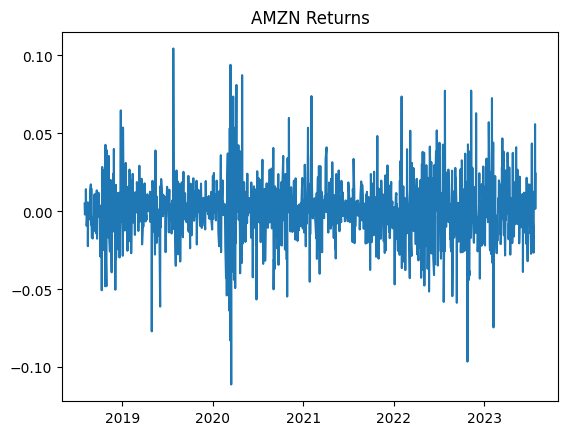

In [4]:
# Plot returns
plt.plot(data_amzn['Return'])
plt.title('AMZN Returns')
plt.show()

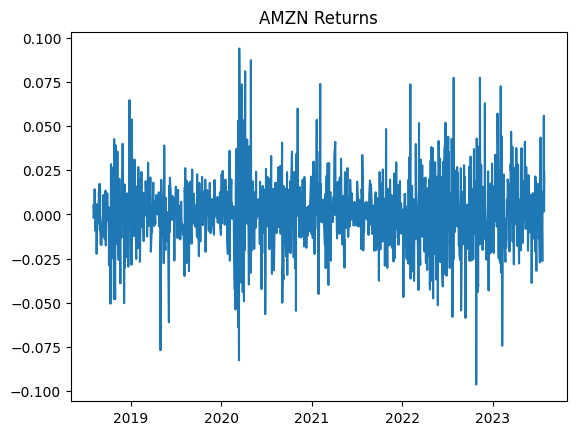

In [5]:
# Drop returns that are bigger than 10% or smaller than -10%
data_amzn = data_amzn[(data_amzn['Return'] < 0.1) & (data_amzn['Return'] > -0.1)]
plt.plot(data_amzn['Return'])
plt.title('AMZN Returns')
plt.show()

In [6]:
ff_data = pd.read_csv('ff_factors.csv').drop(0)
ff_data['Date'] = pd.to_datetime(ff_data['Date'], format='%Y-%m-%d')
ff_data.head()

,Date,Mkt-RF,SMB,HML,RF
1,2018-08-02,0.67,0.31,-0.67,0.007
2,2018-08-03,0.31,-1.07,0.52,0.007
3,2018-08-06,0.46,0.25,-0.34,0.007
4,2018-08-07,0.29,0.03,-0.17,0.007
5,2018-08-08,-0.04,-0.12,0.27,0.007


In [7]:
merged_data = pd.merge(data_amzn, ff_data, on='Date')
merged_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Mkt-RF,SMB,HML,RF
0,2018-08-02,60.294998,61.493999,60.239498,61.307499,61.307499,30626000,0.005033,0.67,0.31,-0.67,0.007
1,2018-08-03,61.480999,61.500000,60.752998,61.185501,61.185501,21792000,-0.001990,0.31,-1.07,0.52,0.007
2,2018-08-06,61.250000,61.304401,60.789848,61.238499,61.238499,21634000,0.000866,0.46,0.25,-0.34,0.007
3,2018-08-07,61.849998,62.558498,61.808498,62.111000,62.111000,29880000,0.014248,0.29,0.03,-0.17,0.007
4,2018-08-08,62.023499,62.825001,61.900398,62.280499,62.280499,27406000,0.002729,-0.04,-0.12,0.27,0.007


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into develop and test sets
train_data, test_data = train_test_split(merged_data, test_size=0.2, shuffle=False)

# Train the model
X_train = train_data[['Mkt-RF', 'SMB', 'HML']]
X_train = sm.add_constant(X_train)
y_train = train_data['Return'] - train_data['RF']

model_train = sm.OLS(y_train, X_train).fit()

# Fit the model
X_test = test_data[['Mkt-RF', 'SMB', 'HML']]
X_test = sm.add_constant(X_test)
y_test = test_data['Return'] - test_data['RF']

y_pred_test = model_train.predict(X_test)

# Calculate the MSE, MAE, MAPE and RMSE for the test set
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_test)
print(f"Test MSE: {mse}")

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred_test)
print(f"Test MAE: {mae}")

mape = np.mean(np.abs((y_test - y_pred_test) / y_test))
print(f"Test MAPE: {mape}")

from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE: {rmse}")

Test MSE: 0.0003665316178895436
Test MAE: 0.01475660976432717
Test MAPE: 1.102992384839202
Test RMSE: 0.01914501548418135


In [9]:
# Print the model summary
print(model_train.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     579.8
Date:                Sat, 09 Dec 2023   Prob (F-statistic):          4.35e-218
Time:                        22:51:17   Log-Likelihood:                 3022.7
No. Observations:                1002   AIC:                            -6037.
Df Residuals:                     998   BIC:                            -6018.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.000     -9.049      0.0

In [10]:
list(model_train.params)

[-0.0033971071251383007,
 0.010951375748732364,
 -0.0019075668764635776,
 -0.003029291540707847]

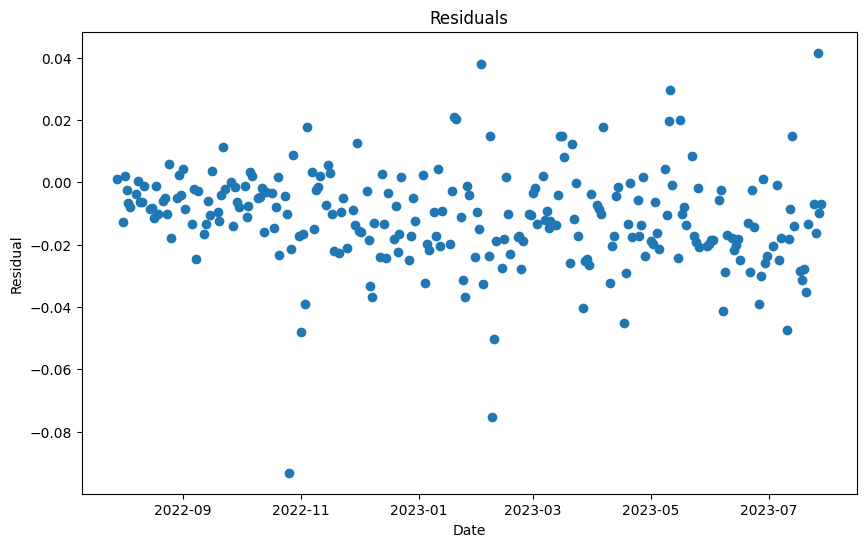

In [11]:
# Plot the residuals of test data
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Date'], y_test - y_pred_test)
plt.title('Residuals')
plt.ylabel('Residual')
plt.xlabel('Date')
plt.show()

Test MSE: 0.0003665316178895436


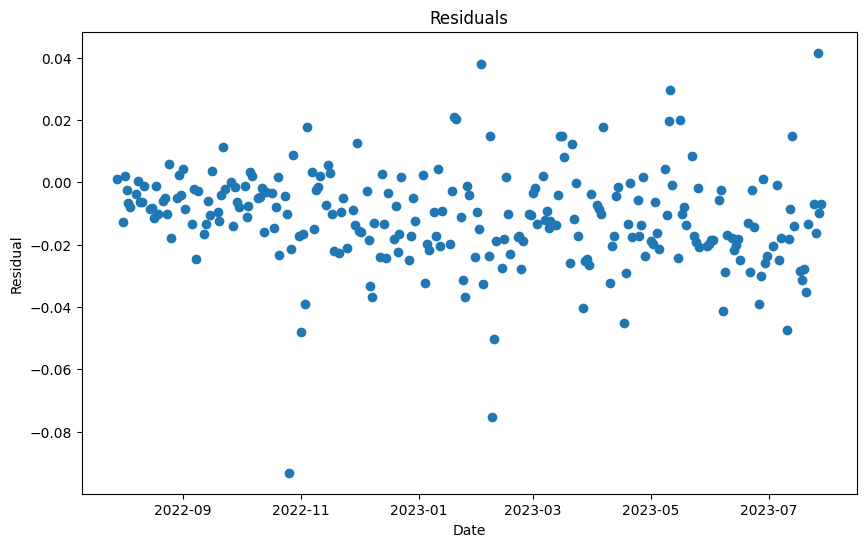

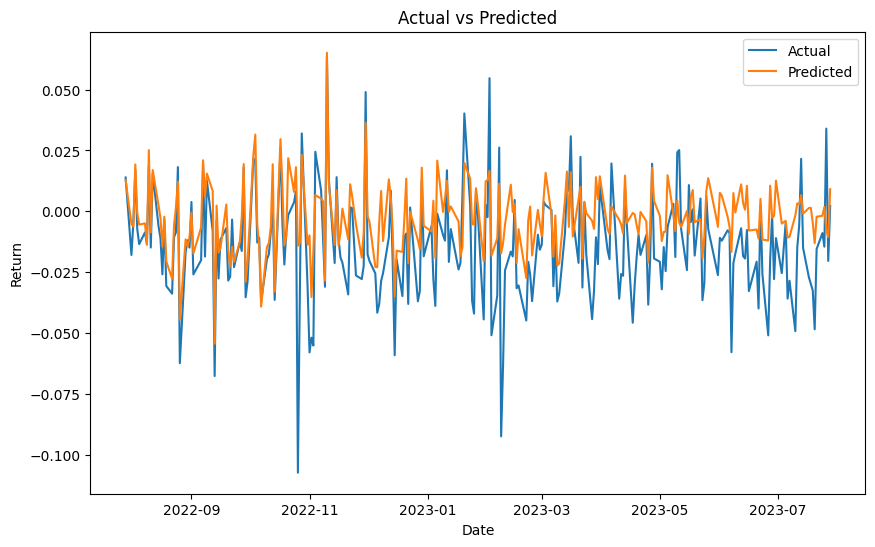

In [12]:
# Use the model to predict the test set
X_test = test_data[['Mkt-RF', 'SMB', 'HML']]
X_test = sm.add_constant(X_test)
y_test = test_data['Return'] - test_data['RF']

y_pred_test = model_train.predict(X_test)

# Calculate the MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_test)
print(f"Test MSE: {mse}")

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Date'], y_test - y_pred_test)
plt.title('Residuals')
plt.ylabel('Residual')
plt.xlabel('Date')
plt.show()

# Plot the actual returns and the predicted returns
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], y_test, label='Actual')
plt.plot(test_data['Date'], y_pred_test, label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Return')
plt.xlabel('Date')
plt.legend()
plt.show()

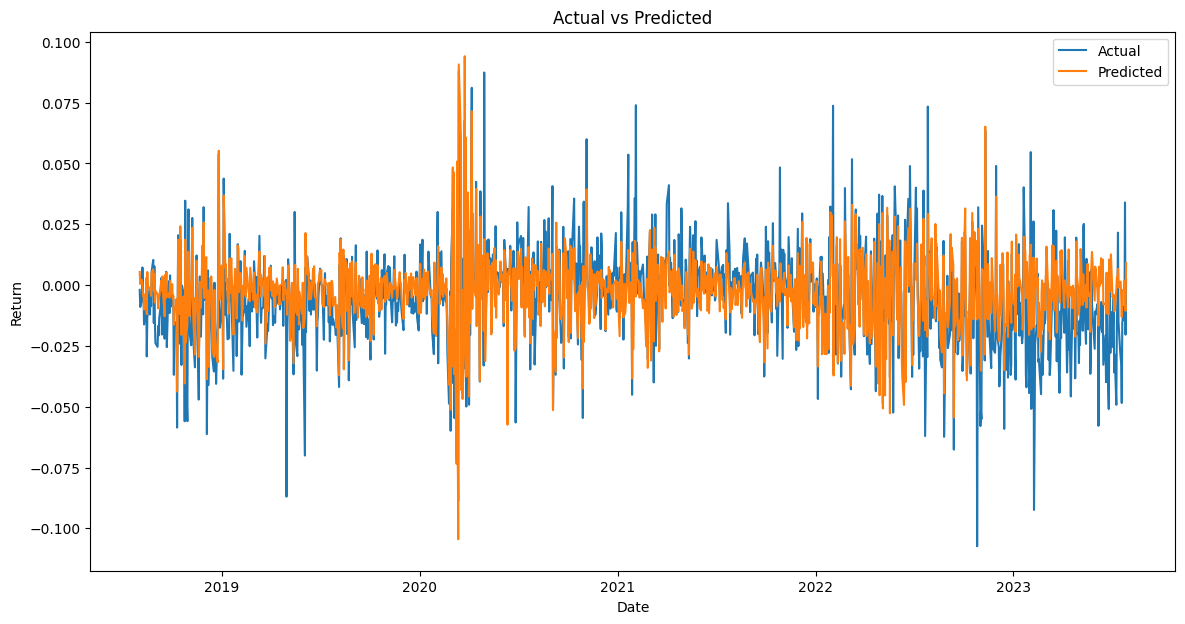

In [32]:
# Use the model to predict the whole dataset
X = merged_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)
y = merged_data['Return'] - merged_data['RF']

y_pred = model_train.predict(X)

# Plot the actual returns and the predicted returns
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], y, label='Actual')
plt.plot(merged_data['Date'], y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Return')
plt.xlabel('Date')
plt.legend()
plt.show()


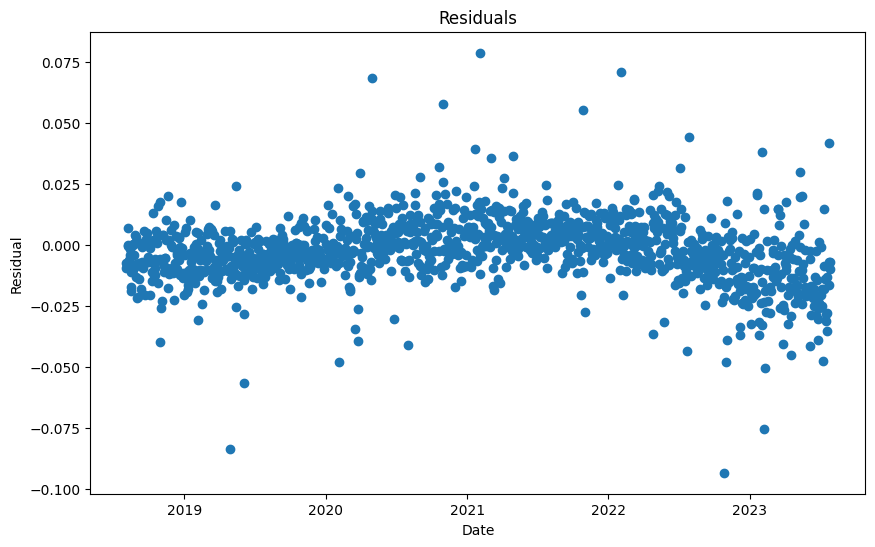

In [14]:
# Combine the residuals from all sets
residuals = y - y_pred
residuals = residuals.to_frame()
residuals.columns = ['Residuals']
residuals.head()

# Combine residuals with Date
residuals = pd.merge(merged_data[['Date']], residuals, left_index=True, right_index=True)

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(residuals['Date'], residuals['Residuals'])
plt.title('Residuals')
plt.ylabel('Residual')
plt.xlabel('Date')
plt.show()

In [15]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error

# Use auto_arima to find the best model
# Use the Residuals gained from Fama-French model
ts_data = residuals['Residuals']

# Split the data into train and test sets
train_data = ts_data[:int(0.8*(len(ts_data)))]
test_data = ts_data[int(0.8*(len(ts_data))):]

# Fit the ARIMA model on the training data
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=2, max_q=2, # maximum p and q
                   m=1,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=False,   # No Seasonality
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Print the summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6043.472, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6062.111, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6058.569, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6070.692, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6164.309, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6166.371, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6164.400, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-6066.378, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6164.181, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6093.057, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.966 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1002
Model:               SARIMAX(1, 0, 1)   Log Likeliho

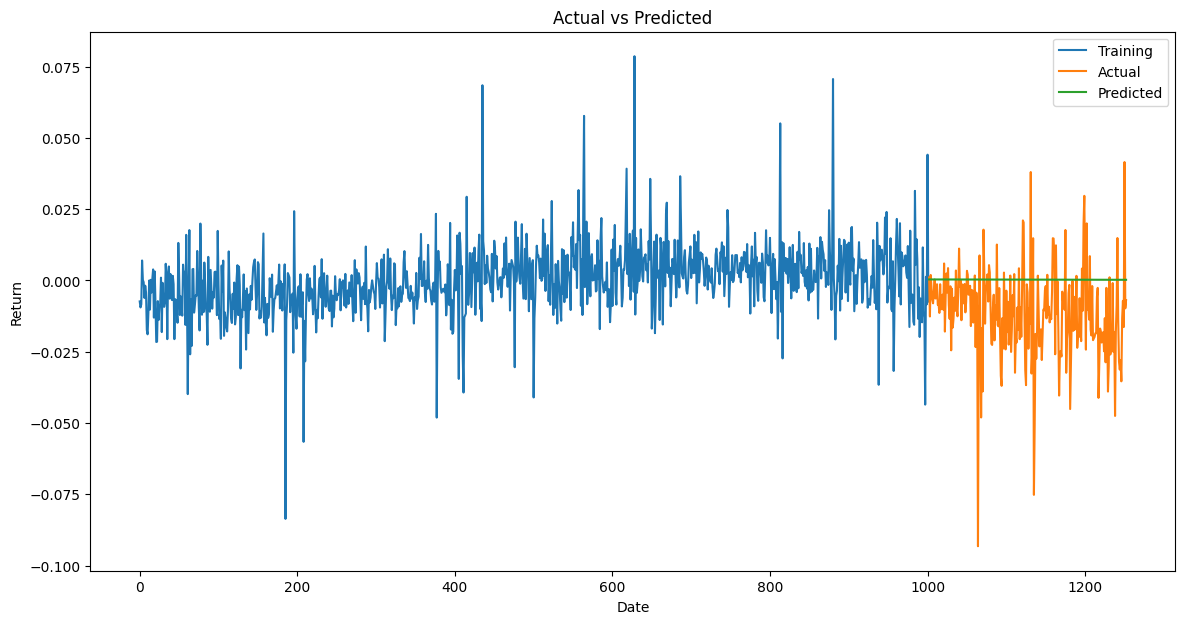

In [31]:
# Get the in-sample predictions
predictions = model.predict_in_sample()

# Forcasting with the fitted model
predictions, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Plot the actual values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Return')
plt.xlabel('Date')
plt.legend()
plt.show()

In [17]:
# Calculate the MSE, RMSE, and MAPE
mse = mean_squared_error(test_data, predictions)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(test_data, predictions)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MSE: 0.00037322217499605534
RMSE: 0.019318958952181026
MAPE: 1.157695052624318


In [18]:
diverse_data = pd.DataFrame()
# Add the date column as the index
diverse_data['Date'] = merged_data['Date'][-251:-1]
diverse_data['Predicted Returns'] = (predictions + 1).cumprod()
diverse_data['Original Stock Price'] = merged_data['Adj Close'][-251:-1]
diverse_data['Predicted Stock Price'] = diverse_data['Predicted Returns'] * 120.970001
diverse_data

,Date,Predicted Returns,Original Stock Price,Predicted Stock Price
1002,2022-07-29,1.000362,116.639999,121.013808
1003,2022-08-01,1.000724,115.480003,121.057556
1004,2022-08-02,1.001085,115.900002,121.101246
1005,2022-08-03,1.001446,118.779999,121.144878
1006,2022-08-04,1.001806,118.870003,121.188451
...,...,...,...,...
1247,2023-07-21,1.075602,120.309998,130.115563
1248,2023-07-24,1.075858,121.879997,130.146602
1249,2023-07-25,1.076115,122.790001,130.177596
1250,2023-07-26,1.076371,129.660004,130.208545


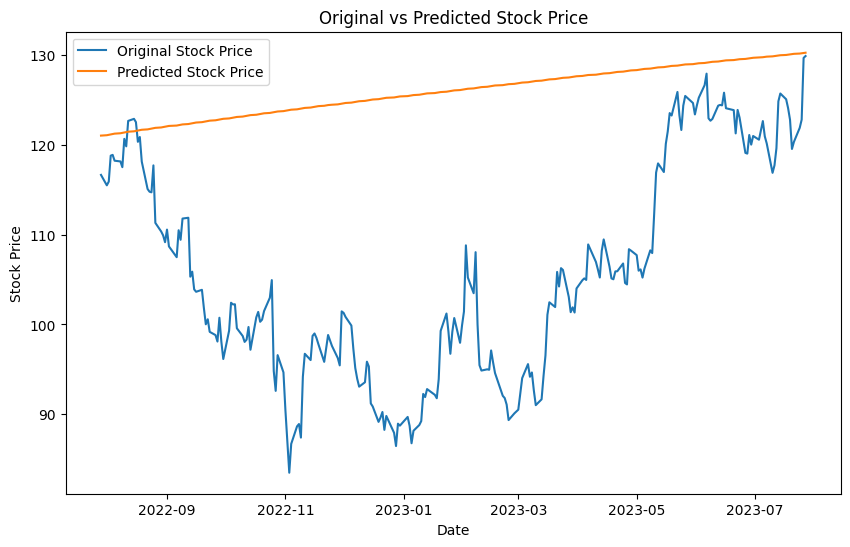

In [19]:
# Plot the predicted stock price and the original stock price
plt.figure(figsize=(10, 6))
plt.plot(diverse_data['Date'], diverse_data['Original Stock Price'], label='Original Stock Price')
plt.plot(diverse_data['Date'], diverse_data['Predicted Stock Price'], label='Predicted Stock Price')
plt.title('Original vs Predicted Stock Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [28]:
diverse_data['Predicted Stock Price']

1002    121.013808
1003    121.057556
1004    121.101246
1005    121.144878
1006    121.188451
           ...    
1247    130.115563
1248    130.146602
1249    130.177596
1250    130.208545
1251    130.239449
Name: Predicted Stock Price, Length: 250, dtype: float64

In [ ]:
merged_data['Adj Close']



0        61.307499
1        61.185501
2        61.238499
3        62.111000
4        62.280499
           ...    
1248    121.879997
1249    122.790001
1250    129.660004
1251    129.869995
1252    133.009995
Name: Adj Close, Length: 1253, dtype: float64

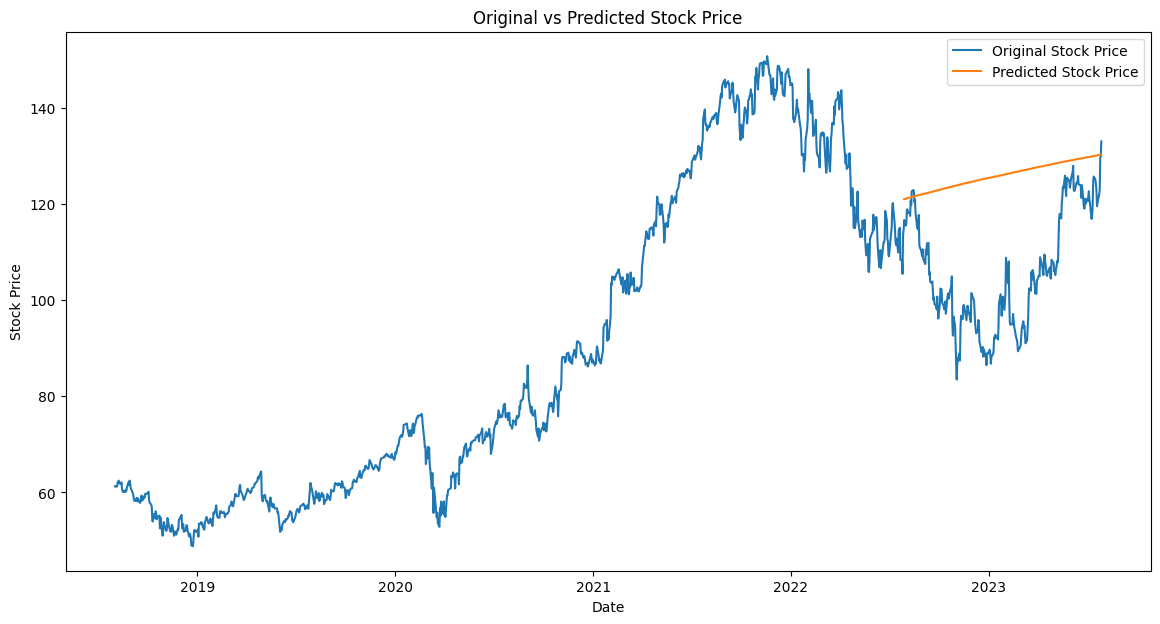

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Adj Close'], label='Original Stock Price')
plt.plot(diverse_data['Date'], diverse_data['Predicted Stock Price'], label='Predicted Stock Price')
plt.title('Original vs Predicted Stock Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.legend()
plt.show()
